
Estadísticas de las simulaciones:
Total de simulaciones: 1000

Distribución de géneros seleccionados:
Drama: 213 veces (21.3%)
Comedia: 207 veces (20.7%)
Acción: 205 veces (20.5%)
SciFi: 202 veces (20.2%)
Documental: 173 veces (17.3%)

Utilidad promedio del ganador: 18.99 ± 1.87

Coincidencia con Borda: 80.40%
Coincidencia con Condorcet: 86.52%


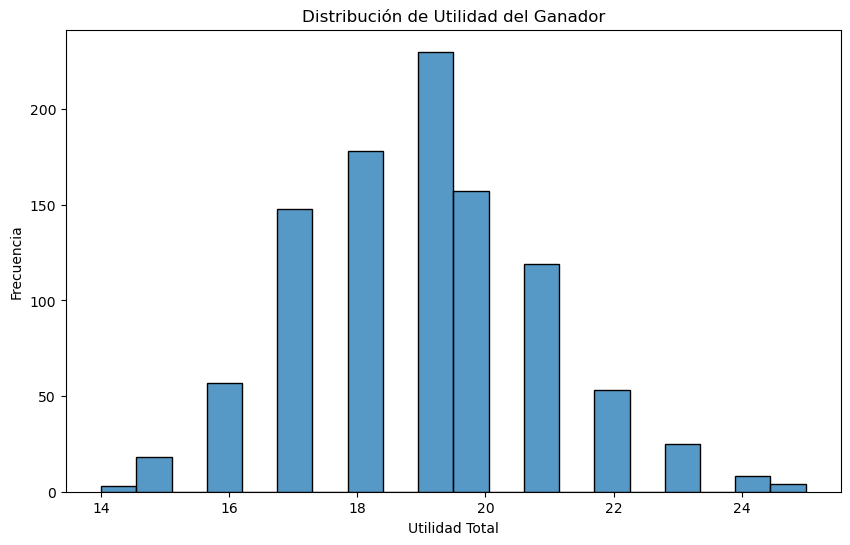

Utilidad media: 18.99, desviación estándar: 1.87

Volatilidad en las decisiones: 81.38%
Índice de concentración (HHI): 0.201


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

def validate_preferences(preferences, possible_places):
    """
    Verifica que las preferencias sean válidas:
    - Al menos 2 personas
    - Mismo número de preferencias que lugares
    - Lugares válidos
    """
    if len(preferences) < 2:
        print("ERROR: Se necesitan al menos 2 personas.")
        return False

    required_places = len(possible_places)
    for person, prefs in preferences.items():
        if len(prefs) != required_places:
            print(f"ERROR: {person} no tiene {required_places} preferencias.")
            return False
        for place in prefs:
            if place not in possible_places:
                print(f"ERROR: {person} incluyó un lugar desconocido {place}.")
                return False

    return True

def generate_random_preferences(num_people, possible_places):
    """
    Genera preferencias aleatorias para num_people personas
    """
    preferences = {}
    for i in range(num_people):
        person_name = f"Persona_{i+1}"
        # Genera una permutación aleatoria de las películas
        random_prefs = random.sample(possible_places, len(possible_places))
        preferences[person_name] = random_prefs
    return preferences

def compute_borda_scores(preferences, possible_places):
    """
    Calcula puntuaciones Borda para cada opción
    """
    n = len(possible_places)
    scores = {place: 0 for place in possible_places}
    
    for person, ranking in preferences.items():
        for i, place in enumerate(ranking):
            scores[place] += (n - 1 - i)
    
    return scores

def borda_winner(preferences, possible_places):
    """
    Determina el ganador según el método Borda
    """
    scores = compute_borda_scores(preferences, possible_places)
    return max(scores, key=scores.get)

def compute_winner_utility(preferences, winner, possible_places):
    """
    Calcula la utilidad total del ganador
    """
    N = len(possible_places)
    total_utility = 0
    for person, ranking in preferences.items():
        index_of_winner = ranking.index(winner)
        total_utility += (N - index_of_winner)
    return total_utility

def pairwise_matrix(preferences, possible_places):
    """
    Crea matriz de comparaciones por pares
    """
    matrix = {x: {y: 0 for y in possible_places} for x in possible_places}
    
    for person, ranking in preferences.items():
        for i, x in enumerate(ranking):
            for j in range(i+1, len(ranking)):
                y = ranking[j]
                matrix[x][y] += 1
    
    return matrix

def find_condorcet_winner(preferences, possible_places):
    """
    Encuentra el ganador Condorcet si existe
    """
    matrix = pairwise_matrix(preferences, possible_places)
    
    for x in possible_places:
        wins_all = True
        for y in possible_places:
            if x == y:
                continue
            if matrix[x][y] <= matrix[y][x]:
                wins_all = False
                break
        if wins_all:
            return x
    return None

def analyze_engine_coincidence(df_sims):
    """
    Analiza coincidencia con métodos Borda y Condorcet
    """
    total_sims = len(df_sims)
    if total_sims == 0:
        return {
            "engine_borda_coincidence": 0.0,
            "engine_condorcet_coincidence": 0.0
        }
    
    same_borda = (df_sims["winner_engine"] == df_sims["winner_borda"]).sum()
    borda_coincidence = same_borda / total_sims
    
    df_condorcet = df_sims.dropna(subset=["winner_condorcet"])
    if len(df_condorcet) > 0:
        same_condorcet = (df_condorcet["winner_engine"] == df_condorcet["winner_condorcet"]).sum()
        condorcet_coincidence = same_condorcet / len(df_condorcet)
    else:
        condorcet_coincidence = 0.0
        
    return {
        "engine_borda_coincidence": borda_coincidence,
        "engine_condorcet_coincidence": condorcet_coincidence
    }

def analyze_winner_volatility(df_sims):
    """
    Calcula volatilidad en las decisiones
    """
    df_ordered = df_sims.sort_values("simulation_id")
    winners = df_ordered["winner_engine"].values
    changes = sum(winners[i] != winners[i-1] for i in range(1, len(winners)))
    return changes / (len(winners) - 1) if len(winners) > 1 else 0

def compute_hhi_winners(df_sims):
    """
    Calcula índice Herfindahl-Hirschman para concentración
    """
    winner_counts = df_sims["winner_engine"].value_counts()
    total = winner_counts.sum()
    proportions = winner_counts / total
    return (proportions**2).sum()

def plot_winner_utility_distribution(df_sims):
    """
    Visualiza distribución de utilidad
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_sims, x="winner_utility", bins=20)
    plt.title("Distribución de Utilidad del Ganador")
    plt.xlabel("Utilidad Total")
    plt.ylabel("Frecuencia")
    plt.show()
    
    mean_util = df_sims["winner_utility"].mean()
    std_util = df_sims["winner_utility"].std()
    print(f"Utilidad media: {mean_util:.2f}, desviación estándar: {std_util:.2f}")

def inference_engine(preferences, possible_places):
    """
    Algoritmo que considera:
    1. Primera preferencia (peso=3)
    2. Última preferencia como veto (peso=-2)
    3. Bonus por consenso: +1 si aparece en top 2 de >50% de votantes
    """
    # Conteo inicial con pesos
    place_scores = {place: 0 for place in possible_places}
    
    # Contar cuántas personas hay
    num_people = len(preferences)
    min_consensus = num_people // 2  # 50% de las personas
    
    for person, pref_list in preferences.items():
        # Primera preferencia tiene peso 3
        top_choice = pref_list[0]
        place_scores[top_choice] += 3
        
        # Última preferencia penaliza con -2
        last_choice = pref_list[-1]
        place_scores[last_choice] -= 2
        
        # Considerar top 2 para consenso
        top_two = set(pref_list[:2])
        for place in top_two:
            place_scores[place] += 1
            
    # Encontrar ganador
    winner = max(place_scores.items(), key=lambda x: x[1])[0]
    return winner

def run_single_simulation(num_people, possible_movies):
    """
    Genera una simulación individual de selección de película
    """
    # Generar preferencias aleatorias
    prefs = generate_random_preferences(num_people, possible_movies)
    
    # Validar
    valid = validate_preferences(prefs, possible_movies)
    if not valid:
        return None
    
    # Ejecutar inference_engine
    chosen_engine = inference_engine(prefs, possible_movies)
    
    # Calcular Borda y Condorcet para comparación
    chosen_borda = borda_winner(prefs, possible_movies)
    chosen_condorcet = find_condorcet_winner(prefs, possible_movies)
    
    # Calcular utilidad del ganador
    winner_utility = compute_winner_utility(prefs, chosen_engine, possible_movies)
    
    # Retornar resultados
    sim_data = {
        'preferences': prefs,
        'winner_engine': chosen_engine,
        'winner_borda': chosen_borda,
        'winner_condorcet': chosen_condorcet,
        'winner_utility': winner_utility
    }
    return sim_data

def run_many_simulations(num_runs, num_people, possible_movies):
    """
    Ejecuta múltiples simulaciones y recopila resultados
    """
    records = []
    for i in range(num_runs):
        sim_data = run_single_simulation(num_people, possible_movies)
        if sim_data is not None:
            sim_data['simulation_id'] = i + 1
            records.append(sim_data)
    
    return pd.DataFrame(records)

# Ejecutar el experimento
if __name__ == "__main__":
    # Configuración
    NUM_RUNS = 1000
    NUM_PEOPLE = 5
    possible_movies = ["Drama", "Comedia", "Acción", "SciFi", "Documental"]

    # Ejecutar simulaciones
    df_sims = run_many_simulations(NUM_RUNS, NUM_PEOPLE, possible_movies)

    # Analizar resultados
    print("\nEstadísticas de las simulaciones:")
    print(f"Total de simulaciones: {len(df_sims)}")

    # Ver distribución de géneros ganadores
    winner_counts = df_sims['winner_engine'].value_counts()
    print("\nDistribución de géneros seleccionados:")
    for genre, count in winner_counts.items():
        percentage = (count/len(df_sims)) * 100
        print(f"{genre}: {count} veces ({percentage:.1f}%)")

    # Calcular utilidad promedio
    mean_utility = df_sims['winner_utility'].mean()
    std_utility = df_sims['winner_utility'].std()
    print(f"\nUtilidad promedio del ganador: {mean_utility:.2f} ± {std_utility:.2f}")

    # Coincidencia con otros métodos
    results = analyze_engine_coincidence(df_sims)
    print(f"\nCoincidencia con Borda: {results['engine_borda_coincidence']:.2%}")
    print(f"Coincidencia con Condorcet: {results['engine_condorcet_coincidence']:.2%}")

    # Visualizar distribución de utilidad
    plot_winner_utility_distribution(df_sims)

    # Analizar estabilidad de las decisiones
    volatility = analyze_winner_volatility(df_sims)
    print(f"\nVolatilidad en las decisiones: {volatility:.2%}")

    # Calcular concentración de ganadores (HHI)
    hhi = compute_hhi_winners(df_sims)
    print(f"Índice de concentración (HHI): {hhi:.3f}")

En este experimento, simulamos un sistema de votación para un club de cine donde 5 personas deben elegir semanalmente qué género de película ver. El sistema genera preferencias aleatorias para cada persona usando la función `generate_random_preferences`, donde cada participante ordena los géneros disponibles (Drama, Comedia, Acción, SciFi, Documental) según sus preferencias. Por ejemplo, una persona podría tener el orden ["Drama", "Comedia", "SciFi", "Documental", "Acción"], indicando que prefiere Drama y menos le gusta Acción. El algoritmo de selección (`inference_engine`) asigna diferentes pesos a las preferencias: +3 puntos para la primera preferencia de cada persona, -2 puntos como penalización si es la última preferencia (actuando como un veto), y +1 punto de bonus si aparece en el top 2 de alguien. Para evaluar qué tan bueno es el sistema, calculamos la utilidad de cada selección usando `compute_winner_utility`, donde la utilidad decrece linealmente según la posición en las preferencias (N-1 puntos para la primera preferencia, N-2 para la segunda, etc.). En un grupo de 5 personas con 5 géneros, la utilidad máxima posible sería 25 (si todos tuvieran el ganador como primera opción) y la mínima 5 (si todos lo tuvieran como última opción). Esta métrica nos permite evaluar qué tan satisfecho está el grupo en general con las selecciones del sistema.
